## **Conventional Categorical Encoding**

## **(1) One-hot Encoding**

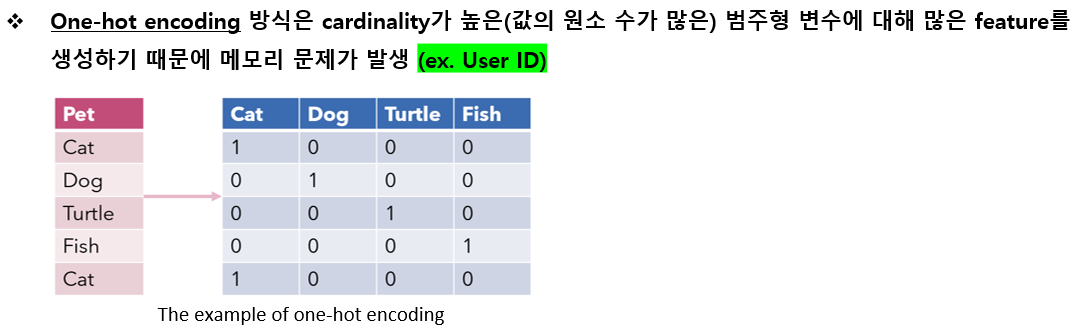

In [ ]:
# 필요한 package 불러오기
import pandas as pd
import numpy as np
import cufflinks as cf
cf.go_offline(connected=True)

In [ ]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0614.git

Cloning into 'DX-Training-LGES-0614'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (64/64), 14.10 MiB | 3.70 MiB/s, done.


In [ ]:
# 데이터 불러오기
df = pd.read_csv("/content/DX-Training-LGES-0614/Data_CB_categorical-encoding.csv", encoding = "UTF-8-sig")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 성별('Sex') 컬럼은 male과 female로 구성되어 있는 categorical 변수임
# 성별 컬럼은 one hot encoding을 통해 0과 1로 이루어진 2개의 컬럼으로 표현 가능함

df = df.join(pd.get_dummies(df['Sex'], prefix='Sex')) # join: prefix 이어서 컬럼명 구성
df[['Sex', 'Sex_female', 'Sex_male']].head()

,Sex,Sex_female,Sex_male
0,male,0,1
1,female,1,0
2,female,1,0
3,female,1,0
4,male,0,1


## **(2) Label Encoding**

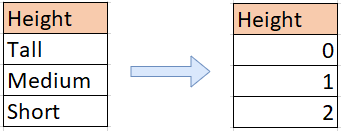

In [ ]:
# 대상 컬럼 확인
df[['Sex']].head()

,Sex
0,male
1,female
2,female
3,female
4,male


In [ ]:
# 성별('Sex') 컬럼은 male과 female로 구성되어 있는 categorical 변수임
# 성별 컬럼은 label encoding을 통해 정수형으로 표현된 하나의 컬럼으로 표현 가능함

df['Sex_label'] = pd.Categorical(df['Sex']).codes # codes: 숫자형태로 변경
df[['Sex', 'Sex_label']].head()

,Sex,Sex_label
0,male,1
1,female,0
2,female,0
3,female,0
4,male,1


## **(3) Target Statistics**
### **(3-1) Mean Encoding**

In [ ]:
# target 변수 설정
target = 'Survived'

In [ ]:
# target 에 대한 sex 내 각 변수의 mean 값을 계산

sex_mean = df.groupby('Sex')[target].mean()
sex_mean

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [ ]:
# 기존 변수에 encoded 된 값을 매핑

df['Sex_mean'] = df['Sex'].map(sex_mean)
df[['Sex', 'Sex_mean']].head()

,Sex,Sex_mean
0,male,0.188908
1,female,0.742038
2,female,0.742038
3,female,0.742038
4,male,0.188908


### **(3-2) Smoothing Statistics**

In [ ]:
# row 수와 global_mean 계산
df['Sex_n_rows'] = df['Sex'].map(df.groupby('Sex').size())
global_mean = df[target].mean()

# smoothing을 위해 alpha 값 임의로 설정
alpha = 0.7

# smoothing 함수
def smoothing(n_rows, target_mean):
    return (target_mean*n_rows + global_mean*alpha) / (n_rows + alpha)

# smoothing statistics 계산
df['Sex_mean_smoothing'] = df.apply(lambda x:smoothing(x['Sex_n_rows'], x['Sex_mean']), axis=1)

In [ ]:
df[['Sex_mean', 'Sex_mean_smoothing']].head()

,Sex_mean,Sex_mean_smoothing
0,0.188908,0.189144
1,0.742038,0.741241
2,0.742038,0.741241
3,0.742038,0.741241
4,0.188908,0.189144


### **(3-3) k-fold Target Statistics**

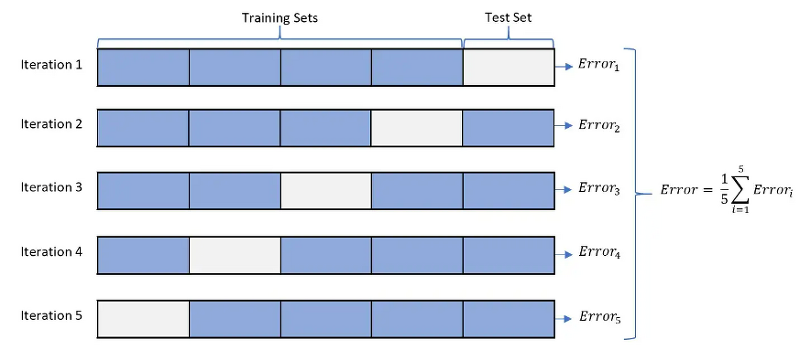

In [ ]:
# train set과 test set 구분을 위한 package 불러오기
from sklearn.model_selection import train_test_split

# encoding에는 train set만 사용됨
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# train으로부터 train_new 생성할 예정이므로, 빈 데이터프레임 생성
train_new = train.copy()
train_new[:] = np.nan
train_new['Sex_mean'] = np.nan

<ipython-input-31-b6f479fbc879>:9: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [ ]:
# k-fold 구분을 위해 package 불러오기
from sklearn.model_selection import StratifiedKFold

# K-fold 만들기 (k=5)
X_train = train.drop(target, axis=1)
Y_train = train[target]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold iteration
for tr_idx, val_idx in skf.split(X_train, Y_train):

    # fold별 train과 val 구분
    X_train, X_val = train.iloc[tr_idx], train.iloc[val_idx]

    # train set에서 구한 mean encoded 값을 validation set에 매핑
    means = X_val['Sex'].map(X_train.groupby('Sex')[target].mean())
    X_val['Sex_mean'] = means
    train_new.iloc[val_idx] = X_val

# 폴드에 속하지못한 데이터들은 글로벌 평균으로 채우기
global_mean = train[target].mean()
print('global mean: ', global_mean)

# NA 값에 대해 global_mean으로 채우기
train_new['Sex'] = train_new['Sex'].fillna(global_mean)

global mean:  0.37640449438202245


In [ ]:
train_new[['Sex', 'Sex_mean']].head()

,Sex,Sex_mean
331,male,0.184987
733,male,0.193029
382,male,0.177419
704,male,0.184000
813,female,0.751269


## **CatBoost (Regression): House Price 예측**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.8 MB/s eta 0:00:00


In [ ]:
# 필요한 package 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0614.git

Cloning into 'DX-Training-LGES-0614'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 67 (delta 1), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (67/67), 14.15 MiB | 6.33 MiB/s, done.


In [ ]:
# 데이터 불러오기
df = pd.read_csv("/content/DX-Training-LGES-0614/Data_CB_reg_Dushanbe-house.csv", encoding = "UTF-8-sig")
del df['Unnamed: 0']

df.head()

,number_of_rooms,floor,area,latitude,longitude,price
0,1,1,58.0,38.585834,68.793715,330000
1,1,14,68.0,38.522254,68.749918,340000
2,3,8,50.0,NaN,NaN,700000
3,3,14,84.0,38.520835,68.747908,700000
4,3,3,83.0,38.564374,68.739419,415000


In [ ]:
# 변수 별 상관성(correlation) 확인
df.corr()

,number_of_rooms,floor,area,latitude,longitude,price
number_of_rooms,1.000000,0.037019,0.749612,0.048279,0.017549,0.594876
floor,0.037019,1.000000,0.281956,0.073479,0.051819,0.094023
area,0.749612,0.281956,1.000000,0.102166,0.076320,0.718130
latitude,0.048279,0.073479,0.102166,1.000000,-0.428405,0.097400
longitude,0.017549,0.051819,0.076320,-0.428405,1.000000,0.056808
price,0.594876,0.094023,0.718130,0.097400,0.056808,1.000000


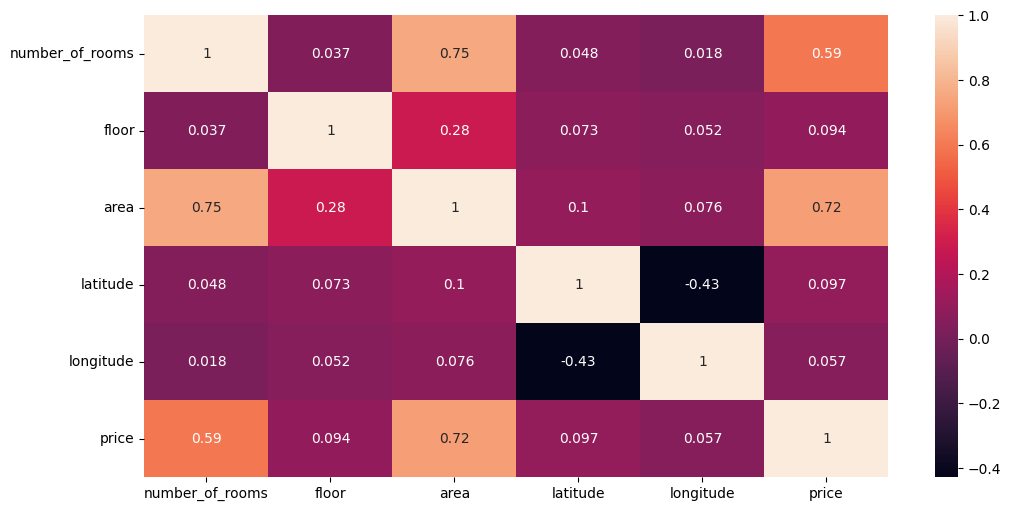

In [ ]:
# 변수 별 상관성(correlation) 확인
corrMatrix = df.corr()

# correaltion matrix heatmap (시각화)
plt.figure(figsize=(12, 6))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Split the data
columns = df.columns

X = df[columns[0:-1]]
y = df[columns[-1]]

In [ ]:
# Train/Test 데이터 구분(test 비율: 25%)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.25, random_state=0)

print("Shape of training input data is :",X_train.shape)
print("Shape of testing input data is :",X_test.shape)

Shape of training input data is : (4184, 5)
Shape of testing input data is : (1395, 5)


In [ ]:
from catboost import CatBoostRegressor
'''
설치하기 : https://catboost.ai/docs/concepts/python-installation.html
conda config --add channels conda-forge
conda install catboost

파라미터 목록 : https://catboost.ai/en/docs/concepts/python-reference_catboostregressor
'''

# initializing the model
cbr = CatBoostRegressor(objective = 'RMSE',
                          iterations= 100,
                          learning_rate = 0.1,
                          max_depth = 6,
                          num_leaves = 31,
                          colsample_bylevel = 0.7,
                          verbose=True)

# training the model
cbr.fit(X_train, y_train)

0:	learn: 412879.8638982	total: 1.47ms	remaining: 146ms
1:	learn: 397258.2792147	total: 7.91ms	remaining: 388ms
2:	learn: 382639.2404289	total: 14.2ms	remaining: 460ms
3:	learn: 368457.2718392	total: 15.7ms	remaining: 377ms
4:	learn: 358184.2232932	total: 21.3ms	remaining: 405ms
5:	learn: 349959.3967796	total: 29ms	remaining: 455ms
6:	learn: 341500.4171939	total: 30.4ms	remaining: 404ms
7:	learn: 331901.8351136	total: 36.3ms	remaining: 418ms
8:	learn: 324262.9102317	total: 41.8ms	remaining: 422ms
9:	learn: 318195.6628367	total: 44.6ms	remaining: 401ms
10:	learn: 312990.9903409	total: 48.1ms	remaining: 389ms
11:	learn: 309203.2080767	total: 50.2ms	remaining: 368ms
12:	learn: 305922.6003761	total: 51.3ms	remaining: 344ms
13:	learn: 302874.0978028	total: 52.6ms	remaining: 323ms
14:	learn: 299176.4763381	total: 58.9ms	remaining: 334ms
15:	learn: 296563.7959451	total: 60.1ms	remaining: 316ms
16:	learn: 291306.5343269	total: 61.5ms	remaining: 300ms
17:	learn: 289377.8984928	total: 66.9ms	rem

In [ ]:
# test data에 대한 예측
cbr_prediction = cbr.predict(X_test)

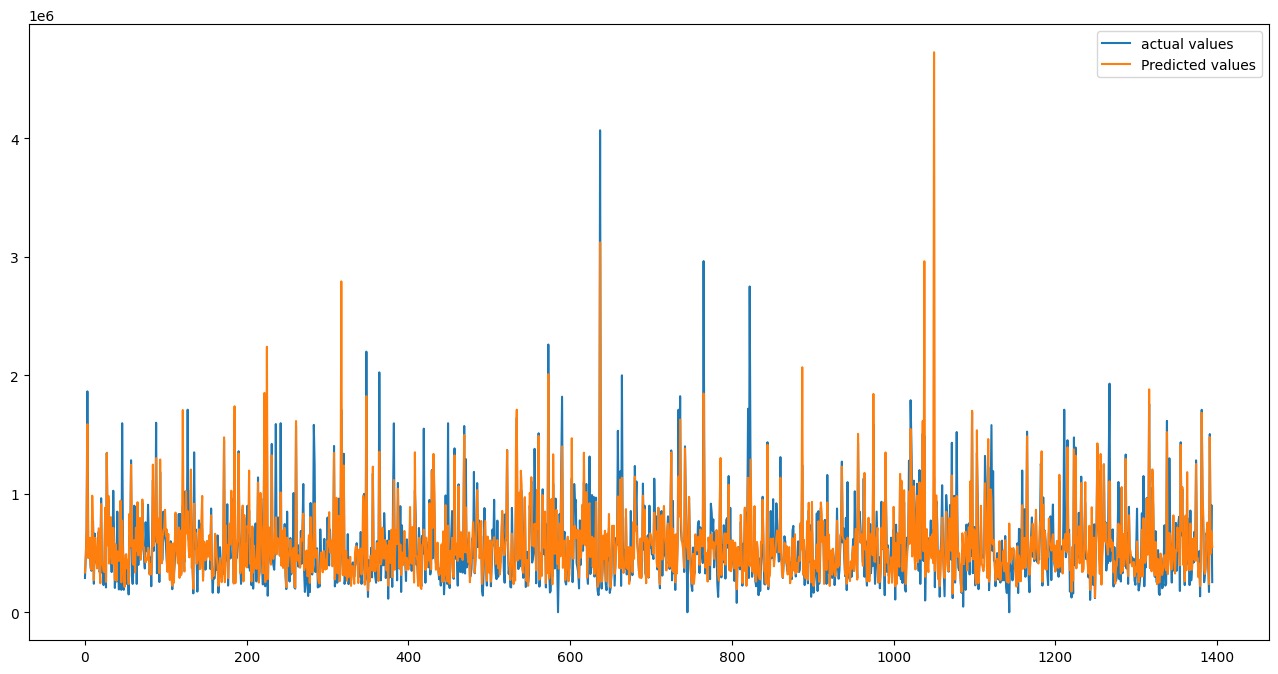

In [ ]:
# 예측값과 실제값 차이를 확인하기 위한 시각화

plt.figure(figsize=(16, 8))
plt.plot([i for i in range(len(y_test))],y_test, label="actual values")
plt.plot([i for i in range(len(y_test))],cbr_prediction, label="Predicted values")
plt.legend()
plt.show()

In [ ]:
# 예측 값과 실제 값 간의 차이(오차) 계산
# Mean Abolute Error (MAE)
cat_mae = mean_absolute_error(y_test, cbr_prediction)

# Mean Squared Error (MSE)
cat_mse = mean_squared_error(y_test, cbr_prediction)

# Root Mean Squared Error (RMSE)
cat_rmse = (np.sqrt(mean_squared_error(y_test, cbr_prediction)))

# 예측값과 실제 값 간의 R^2(결정 계수) 계산
# 분산 기반으로 예측 성능을 평가 / 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
cat_r2 = r2_score(y_test, cbr_prediction)

print("Testing performance")
print('MAE: {:.4f}'.format(cat_mae))
print('MSE: {:.4f}'.format(cat_mse))
print('RMSE: {:.4f}'.format(cat_rmse))
print('R2: {:.4f}'.format(cat_r2))

Testing performance
MAE: 122430.6290
MSE: 46607622789.9573
RMSE: 215887.9867
R2: 0.6364


In [ ]:
sorted_feature_importance = cbr.feature_importances_.argsort()
sorted_feature_importance

array([1, 0, 4, 3, 2])

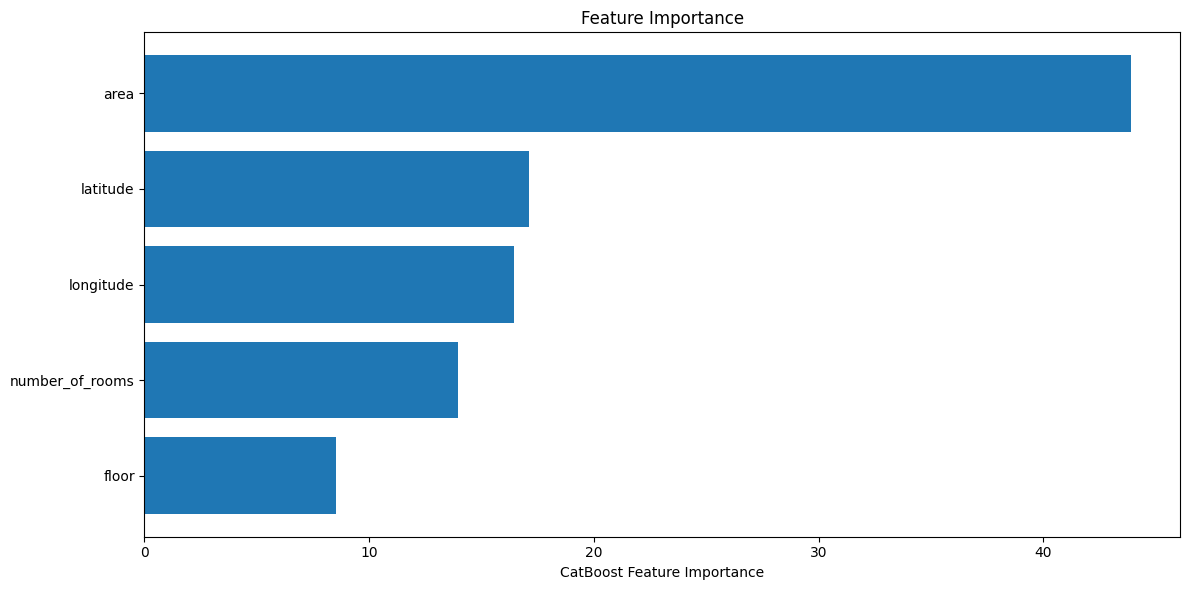

In [ ]:
# feature importance 산출 / 값이 높을수록 해당 피처의 피처 중요도가 높다고 해석할 수 있음
# feature_importance를 높은 순서로 정렬
sorted_feature_importance = cbr.feature_importances_.argsort()

fig, ax = plt.subplots(figsize=(12, 6))
plt.barh(X_train.columns[sorted_feature_importance],
         cbr.feature_importances_[sorted_feature_importance])
plt.title('Feature Importance')
plt.xlabel("CatBoost Feature Importance")
fig.tight_layout()
plt.show()

## **CatBoost (Classification): 가입자 이탈률 예측**

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00


In [ ]:
# 필요한 package 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import catboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0614.git

Cloning into 'DX-Training-LGES-0614'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 69 (delta 2), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (69/69), 14.15 MiB | 2.62 MiB/s, done.


In [ ]:
'''
가입자 이탈/이탈률 dataset : 전체 19개 피처와 1개의 타겟으로 구성 (Categorical feature: State, Area_code, Int.l.Plan, VMail.Plan)
타겟명: 'Churn.' / True(1)는 이탈한 고객, False(0)는 이탈하지 않은 고객을 의미함
'''

# 데이터 불러오기
churn = pd.read_csv("/content/DX-Training-LGES-0614/Data_CB_cls_churn.csv", encoding = "UTF-8-sig")

print('dataset shape:', churn.shape)

# 데이터 확인 (첫 3개 instances)
churn.head()

dataset shape: (3333, 20)


,State,Account.Length,Area.Code,Int.l.Plan,VMail.Plan,VMail.Message,Day.Mins,Day.Calls,Day.Charge,Eve.Mins,Eve.Calls,Eve.Charge,Night.Mins,Night.Calls,Night.Charge,Intl.Mins,Intl.Calls,Intl.Charge,CustServ.Calls,Churn.
0,KS,128,415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [ ]:
#데이터 전처리

# column name 중 "."을 "_"으로 변경
churn.columns = churn.columns.str.replace(".","_")

# data 중 Area.Code는 지역숫자로 수치형이 아니기 때문에, category로 변경
churn.Area_Code = churn.Area_Code.astype("category")

# 독립변수(Xs)와 종속변수(Y) 구분
y_labels = "Churn_" # y_labels에는 타겟 column name 할당
X_features = churn.columns[churn.columns != y_labels].tolist() # X_features에 그 외 column name 할당

# set X_features and y_labels for CatBoost
X_features = churn.drop(['Churn_'], axis=1)
y_labels = churn['Churn_']

# 타겟 변수에 대해 불만족한 고객 ('True.')을 1로, 나머지는 0으로 해서 최종적으로 binary class {1, 0}로 변경
# CatBoost package needs {1, 0} target values for binary classification
y_labels = np.where(y_labels == "True.", 1, 0)

# 학습 데이터와 테스트 데이터 구분 (비율 8:2)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, train_size=0.8, test_size = 0.2, random_state=0)

<ipython-input-8-f7d071cf0973>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  churn.columns = churn.columns.str.replace(".","_")


In [ ]:
from catboost import CatBoostClassifier, Pool

# CatBoost 수행 시간 측정을 위해, 시작 시간 설정
start_time = time.time()

# dataframe에서 category, object 형식의 column의 위치를 출력
cat_features = np.where(X_features.dtypes.astype("str").isin(["category","object"]))[0]

'''
설치하기 : https://catboost.ai/docs/concepts/python-installation.html
conda config --add channels conda-forge
conda install catboost

파라미터 목록 : https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
'''
# 모델 설정 및 train dataset으로 fitting (학습)
CatBoost = CatBoostClassifier(objective = 'Logloss',
                           iterations= 100,
                           learning_rate = 0.1,
                           max_depth = 6,
                           num_leaves = 31,
                           colsample_bylevel = 0.7,
                           random_seed = 0,
                           verbose=True)

CatBoost.fit(X = X_train, y = y_train, cat_features = cat_features, eval_set=[(X_test, y_test)])

# CatBoost 실험 종료에 대한 시간 측정
CatBoost_time = time.time() - start_time

0:	learn: 0.6364702	test: 0.6371079	best: 0.6371079 (0)	total: 53.1ms	remaining: 5.26s
1:	learn: 0.5859698	test: 0.5875588	best: 0.5875588 (1)	total: 57.6ms	remaining: 2.82s
2:	learn: 0.5425757	test: 0.5450588	best: 0.5450588 (2)	total: 62.3ms	remaining: 2.01s
3:	learn: 0.5118435	test: 0.5146578	best: 0.5146578 (3)	total: 66.3ms	remaining: 1.59s
4:	learn: 0.4864354	test: 0.4894250	best: 0.4894250 (4)	total: 70.6ms	remaining: 1.34s
5:	learn: 0.4575620	test: 0.4607449	best: 0.4607449 (5)	total: 74.4ms	remaining: 1.17s
6:	learn: 0.4344348	test: 0.4379555	best: 0.4379555 (6)	total: 77.8ms	remaining: 1.03s
7:	learn: 0.4134218	test: 0.4167203	best: 0.4167203 (7)	total: 81.2ms	remaining: 934ms
8:	learn: 0.3928902	test: 0.3961350	best: 0.3961350 (8)	total: 85ms	remaining: 860ms
9:	learn: 0.3791924	test: 0.3820593	best: 0.3820593 (9)	total: 88.5ms	remaining: 796ms
10:	learn: 0.3592989	test: 0.3613575	best: 0.3613575 (10)	total: 92.2ms	remaining: 746ms
11:	learn: 0.3445520	test: 0.3469857	best: 

In [ ]:
# feature와 target 변수를 합하여 data frame 재구성
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# 학습한 CatBoost 모델을 통해 테스트 데이터를 예측하고, 그 결과를 AUC 및 정확도 기준으로 평가
CatBoost_eval = CatBoost.eval_metrics(test_pool, ['AUC','Accuracy'], plot=False)
maxAUC_index = np.argmax(CatBoost_eval['AUC'])

CatBoost_AUC = CatBoost_eval['AUC'][maxAUC_index]
CatBoost_Accuracy = CatBoost_eval['Accuracy'][maxAUC_index]

print("AUC : ", CatBoost_AUC)
print("Accuracy: ", CatBoost_Accuracy)

AUC :  0.9175694771549694
Accuracy:  0.9580209895052474


In [ ]:
# pred 변수에 실제값 추가
pred = pd.DataFrame(y_test)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = CatBoost.predict(X_test)

pred.head()

,0,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1


In [ ]:
# Precision/Recall/F1-score/Accuracy 계산

print(classification_report(pred[0], pred.pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       579
           1       0.88      0.78      0.83        88

    accuracy                           0.96       667
   macro avg       0.93      0.88      0.90       667
weighted avg       0.96      0.96      0.96       667

